# Поиск токсичных комментариев с помощью BERT

Интернет-магазин запускает новый сервис — теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть, клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию

---

**Цель исследования:** обучить модель, способную классифицировать комментарии как позитивные или негативные

---

**План выполнения работы:**

- загрузка, предварительное изучение и исследовательский анализ данных
- предобработка текста
- подготовка данных к обучению с помощью BERT
- обучение моделей
- анализ результатов

Каждый шаг исследования заканчивается промежуточным выводом. В конце исследования даётся общий подробный вывод

---

- в распоряжении имеется набор данных с разметкой о токсичности правок
- итоговая метрика F1 получившейся модели должна быть не меньше 0.75

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# обновление seaborn

!pip install --upgrade seaborn -q

In [3]:
# установка необходимых модулей

!pip install transformers -q
!pip install torch -q --no-warn-script-location
!pip install catboost -q

In [4]:
# импорт библиотек

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import copy
from time import time
from sklearn.utils import shuffle
from IPython.display import display

import torch 
import transformers
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel

from tqdm import notebook
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# контсанты

RANDOM_STATE = 42
TEST_SIZE = 0.25
TARGET = 'toxic'
MODEL_NAME = 'unitary/toxic-bert'

---

In [6]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [7]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [8]:
def value_counts(data, col, data_name):
                
    """
    Функция value_counts выводит на экран числовое распределение данных в категориальном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Распределение данных в столбце {col} таблицы {data_name}:')
    print(' ')
    print(data[col].value_counts())

In [9]:
def barplot(data, col, xlabel, title):
            
    """
    Функция barplot выводит на экран готовую столбчатую диаграмму размером 8х4 дюйма, 
    содержащую значения относительно частоты встречаемых значений

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    title (str) : название графика
    
    """
    
    sns.set(style='darkgrid')
    plt.figure(figsize=(8, 4))

    data_new = data[col].value_counts(normalize=True)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    unique_values = len(data_new_)
    palette = sns.color_palette("Blues", unique_values)
    
    ax = sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, legend=False)

    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height() * 100) + '%',
                fontsize=8, ha='center', va='bottom')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel('Частота')

    plt.show()

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка, предварительное изучение и исследовательский анализ данных
</div>

---

In [12]:
# загрузка данных

pth1 = 'D:/datasets/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    comments = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    comments = pd.read_csv(pth2, index_col=0)
else:
    print('Что-то пошло не так!')

In [13]:
# изучим общую информацию о таблице

get_info(comments)

Пять случайных строк таблицы:


,text,toxic
47829,Sandbox \n\nHi EnigmaJohn. I've moved the Sale...,0
89934,"203.124.2.14]] 07:29, 27 July",0
124286,List of presidents of European Union instituti...,0
60118,User:CardMaster21 \n\nThis guy plagiarized you...,0
8710,"Elsa Cladera de Bravo \n\nHi, I have tried man...",0


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


In [14]:
# проверим таблицу на наличие пропусков и дубликатов

preprocess(comments, 'comments')

В таблице comments не найдено ни одного пропуска!
В таблице comments не найдено ни одного дубликата!


- столбец `text`, согласно описанию данных, содержит текст комментариев, а столбец `toxic` — целевой признак, является комментарий токсичным или нет (где 1 — комментарий токсичен, 0 — нет)
- таблица содержит 159292 наблюдений
- пропусков и дубликатов в данных нет
- типы данных отображены верно

In [15]:
# посмотрим на числовое распределение данных в столбце toxic

value_counts(comments, 'toxic', 'comments')

Распределение данных в столбце toxic таблицы comments:
 
toxic
0    143106
1     16186
Name: count, dtype: int64


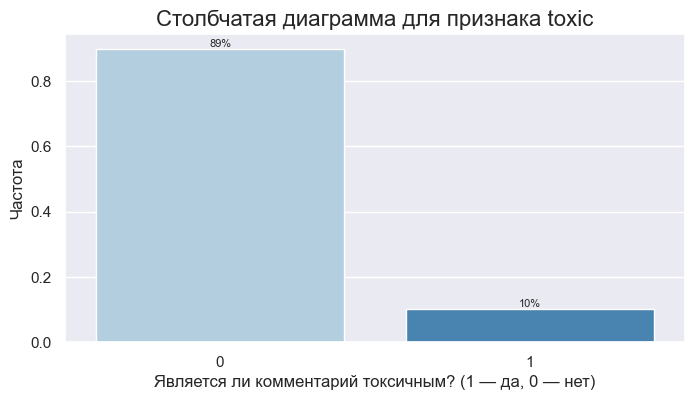

In [16]:
# рассмотрим распределение признака на графике

barplot(comments, 'toxic', 'Является ли комментарий токсичным? (1 — да, 0 — нет)', 'Столбчатая диаграмма для признака toxic')

90% комментариев не являются токсичными. Наблюдаем сильный дисбаланс классов. Устранять его мы, конечно, не будем — важно, чтобы модель справлялась с реальным потоком несбалансированных данных, но учтём этот факт в дальнейшей работе

In [17]:
# разделим данные на обучающую и тестовую выборки с сохранением распределения классов

comments_sampled, _, _, _ = train_test_split(
    comments,
    comments[TARGET],
    test_size = 2000,
    stratify = comments[TARGET],
    random_state = RANDOM_STATE)

In [18]:
# проверим размерность полученной подвыборки

print(comments_sampled.shape)

(157292, 2)


In [19]:
# снова посмотрим на числовое распределение данных в столбце toxic

value_counts(comments_sampled, 'toxic', 'comments')

Распределение данных в столбце toxic таблицы comments:
 
toxic
0    141309
1     15983
Name: count, dtype: int64


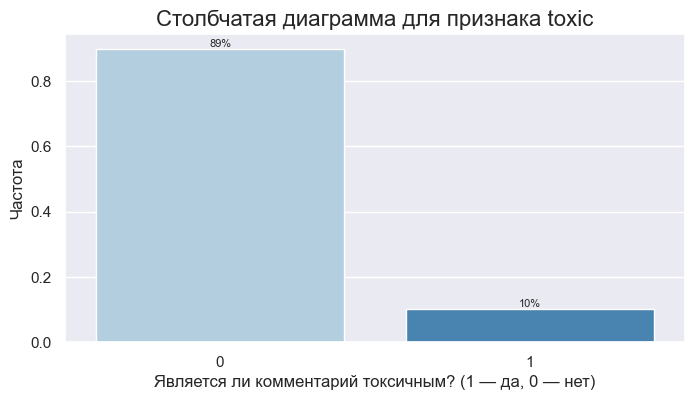

In [20]:
# снова оценим баланс классов с помощью графика

barplot(comments_sampled, 'toxic', 'Является ли комментарий токсичным? (1 — да, 0 — нет)', 'Столбчатая диаграмма для признака toxic')

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка текста
</div>

---

In [21]:
def uncover_reduction(string):
    
    """
    Функция uncover_reduction заменяет символы ’ на '
    и устраняет англоязычные сокращения в тексте
    
    Аргументы:
    string : строка
    
    """

    string_tmp = string.replace('’', "'")
    
    if (string_tmp.find("'") == -1):
        return string_tmp
    
    parts = ("'s ", "'t ", "'ll ", "'ve ", "'m ", "'d ", "'re ")
    founded = False
    for part in parts:
        if (string_tmp.find(part) != -1):
            founded = True
            break;
    
    if not founded:
        return string_tmp

    for key, value in reduction_dict.items():
        string_tmp = string_tmp.replace(key, value)
        
    return string_tmp

In [22]:
def clean_text(string):
                                                    
    """
    Функция clean_text заменяет указанные символы на пробелы, 
    удаляет все знаки препинания, цифры и другие символы, оставляя только буквы и пробелы
    
    Аргументы:
    string (str) : строка

    """
    
    string = re.sub(r"[\n\r]", " ", string)
    string = re.sub(r"[^a-zA-Z ]+", "", string)
    
    return string.strip()

---

In [23]:
# приведём текст комментариев к нижнему регистру и создадим новый столбец с обновлённым текстом

comments_sampled['text_prepared'] = comments_sampled['text'].str.lower()

In [24]:
# проверим результат

get_info(comments_sampled)

Пять случайных строк таблицы:


,text,toxic,text_prepared
1057,At school I was taught that the gravitational ...,0,at school i was taught that the gravitational ...
150272,Thanks. (T / C / WP:FOUR / WP:CHICAGO / WP:WAW...,0,thanks. (t / c / wp:four / wp:chicago / wp:waw...
74643,""":::::::::::::(To Penguin) I'm ROFL, so I'll s...",0,""":::::::::::::(to penguin) i'm rofl, so i'll s..."
140032,Responded to your email.,0,responded to your email.
108200,Reply: Lankaweb like Asia Tribune is not a ...,0,reply: lankaweb like asia tribune is not a ...


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 157292 entries, 68067 to 140046
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           157292 non-null  object
 1   toxic          157292 non-null  int64 
 2   text_prepared  157292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.8+ MB
None


Видим в тексте много сокращений, сочетаний определённых слов. Перед применением BERT попробуем выполнить максимальную предобработку текста — избавимся от этих сокращений и очистим текст. Это может положительно повлиять на конечную метрику

In [26]:
# напишем словарь, в котором каждая пара ключ-значение представляет собой сокращённое слово и его полную форму
    
reduction_dict = {}
reduction_dict.update({
    "i'm" : 'i am',
    "i'd" : 'i had',
    "i'll" : 'i will',
    "i've" : 'i have',
    "you're" : 'you are',
    "you'd" : 'you had',
    "you'll" : 'you will',
    "you've" : 'you have',
    "he's" : 'he is',
    "he'd" : 'he had',
    "he'll" : 'he will',
    "she's" : 'she is',
    "she'd" : 'she had',
    "she'll" : 'she will',
    "it's" : 'it is',
    "it'll" : 'it will',
    "we're" : 'we are',
    "we'd" : 'we would',
    "we'll" : 'we will',
    "we've" : 'we have',
    "they're" : 'they are',
    "they'd" : 'they had',
    "they'll" : 'they will',
    "they've" : 'they have',
    "there's" : 'there is',
    "there'll" : 'there will',
    "there'd" : 'there would',
    "that's" : 'that is',
    "isn't" : 'is not',
    "aren't" : 'are not',
    "don't" : 'do not',
    "doesn't" : 'does not',
    "wasn't" : 'was not',
    "weren't" : 'were not',
    "didn't" : 'did not',
    "haven't" : 'have not',
    "hasn't" : 'has not',
    "won't" : 'will not',
    "hadn't" : 'had not',
    "can't" : 'can not',
    "couldn't" : 'could not',
    "mustn't" : 'must not',
    "mightn't" : 'might not',
    "needn't" : 'need not',
    "shouldn't" : 'should not',
    "oughtn't" : 'ought not',
    "wouldn't" : 'would not',
    "what's" : 'what is',
    "how's" : 'how is',
    "where's": 'where is'
})

In [27]:
# применим функцию uncover_reduction, сохранив обновлённый текст в новый столбец

comments_sampled['text_prepared'] = comments_sampled['text_prepared'].apply(uncover_reduction)

In [28]:
# проверим результат

comments_sampled[['text', 'text_prepared']].head()

,text,text_prepared
68067,"Thank for the discussion. On second thought, I...","thank for the discussion. on second thought, i..."
95016,"Revert on January 19, 2007\n\nI have reverted ...","revert on january 19, 2007\n\ni have reverted ..."
156814,I am under attack! \n\nYou guys are censoring ...,i am under attack! \n\nyou guys are censoring ...
26991,"And for what it's worth, the Constitution also...","and for what it is worth, the constitution als..."
42097,Re Fauna of Puerto Rico\n\nSorry. I am glad yo...,re fauna of puerto rico\n\nsorry. i am glad yo...


In [29]:
# применим функцию для очистки текста

comments_sampled['text_cleared'] = comments_sampled['text_prepared'].apply(clean_text)

In [30]:
# проверим результат

comments_sampled[['text', 'text_prepared', 'text_cleared']].head()

,text,text_prepared,text_cleared
68067,"Thank for the discussion. On second thought, I...","thank for the discussion. on second thought, i...",thank for the discussion on second thought i a...
95016,"Revert on January 19, 2007\n\nI have reverted ...","revert on january 19, 2007\n\ni have reverted ...",revert on january i have reverted the follo...
156814,I am under attack! \n\nYou guys are censoring ...,i am under attack! \n\nyou guys are censoring ...,i am under attack you guys are censoring any...
26991,"And for what it's worth, the Constitution also...","and for what it is worth, the constitution als...",and for what it is worth the constitution also...
42097,Re Fauna of Puerto Rico\n\nSorry. I am glad yo...,re fauna of puerto rico\n\nsorry. i am glad yo...,re fauna of puerto rico sorry i am glad you h...


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Текст комментариев приведён к нижнему регистру, слова-сокращения приведены в полную форму, удалены лишние символы. Конечный результат этого шага сохранён в столбце `text_cleared`
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Подготовка данных к обучению
</div>

---

In [31]:
def split(data, target):
                                        
    """
    Функция split делит данные на тренировочную и тестовую выборки
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : целевой признак
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        data,
        target,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    return X_train, X_test, y_train, y_test

In [32]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

---

In [38]:
# инициализируем BERT

model = AutoModel.from_pretrained(MODEL_NAME)

# инициализируем предварительно обученный токенизатор

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [39]:
# токенизируем подготовленный текст

tokenized = comments_sampled['text_cleared'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

In [40]:
# найдем максимальную длину токенов

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [41]:
# ограничим длину токенов и создадим маску

padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [42]:
# проверим результат

display(padded.shape, attention_mask.shape)

(2000, 512)

(2000, 512)

In [55]:
# получим эмбеддинги

start = time()

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].numpy())
    
end = time()

print(f'Времени прошло, минут: {(end - start) / 60}')

  0%|          | 0/20 [00:00<?, ?it/s]

Времени прошло, минут: 15.899430139859517


In [56]:
# соберем все эмбеддинги в один массив

X = np.concatenate(embeddings)
y = comments_sampled[TARGET]

In [57]:
# разделим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = split(X, y)

In [58]:
# проверим результат

train_test_size(X_train, X_test, y_train, y_test)

Тренировочная выборка
Размерность матрицы со входными признаками: (1500, 768)
Размерность матрицы с целевым признаком: (1500,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (500, 768)
Размерность матрицы с целевым признаком: (500,)


---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

In [ ]:
def run_grid_search(model, params):
                                        
    """
    Функция run_grid_search инициализирует GridSearchCV и выполняет поиск лучших гиперпараметров для модели
    
    Аргументы:
    model : инициализированная модель машинного обучения
    params (dict) : словарь с гипепараметрами

    Возвращает:
    gs : готовую модель с лучшими параметрами
    gs_best_score : метрика F1 на тренировочной выборке
    gs_best_params : список лучших параметров модели
    
    """
    
    gs = GridSearchCV(model, params, n_jobs=-1, cv=5, scoring='f1')
    gs.fit(X_train, y_train)
    gs_best_score = gs.best_score_
    gs_best_params = gs.best_params_
    
    return gs, gs_best_score, gs_best_params

In [ ]:
def run_randomized_search(model, params):
                                            
    """
    Функция run_randomized_search инициализирует RandomizedSearchCV и выполняет поиск лучших гиперпараметров для модели
    
    Аргументы:
    model : инициализированная модель машинного обучения
    params (dict) : словарь с гипепараметрами

    Возвращает:
    rs : готовую модель с лучшими параметрами
    rs_best_score : метрика F1 на тренировочной выборке
    rs_best_params : список лучших параметров модели
    
    """
    
    rs = RandomizedSearchCV(model, param_distributions=params, scoring='f1', n_iter=100)
    rs.fit(X_train, y_train)
    rs_best_score = rs.best_score_
    rs_best_params = rs.best_params_

    return rs, rs_best_score, rs_best_params

In [ ]:
def show_cv_results(score, params, model_name):
                                                
    """
    Функция show_cv_results выводит на экран результаты кросс-валидации модели
    
    Аргументы:
    score : метрика F1 на тренировочной выборке
    params (dict) : словарь с гипепараметрами
    model_name (str) : имя модели

    """
    
    print(model_name)
    print('')
    print(f'Метрика F1 на тренировочной выборке: {score}')
    print(f'Лучшие параметры модели: {params}')

---

## `LogisticRegression`

In [59]:
# инициализируем модель

model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

In [60]:
# запишем гиперпараметры для модели

params_lr = {'C': range(1, 10)}

In [63]:
# выполним кросс-валидацию

start_lr = time()

lr, score_lr, best_params_lr = run_grid_search(model_lr, params_lr)

end_lr = time()

lr_time = (end_lr - start_lr)
print(f'Время, затраченное на кросс-валидацию, секунд: {lr_time}')

C:\Users\User_\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
# оценим результат

results_lr = show_cv_results(score_lr, best_params_lr, 'LogisticRegression')

LogisticRegression

Метрика F1 на тренировочной выборке: 0.9188733207837767
Лучшие параметры модели: {'C': 3}


## `DecisionTreeClassifier`

In [67]:
# инициализируем модель

model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [68]:
# запишем гиперпараметры для модели

params_dt = {
        'max_depth': range(1, 15),
        'max_features': range(1, 160)
}

In [69]:
# выполним кросс-валидацию

start_dt = time()

dt, score_dt, best_params_dt = run_grid_search(model_dt, params_dt)

end_dt = time()

dt_time = (end_dt - start_dt) / 60
print(f'Время, затраченное на кросс-валидацию, минут: {dt_time}')

In [71]:
# оценим результат

results_dt = show_cv_results(score_dt, best_params_dt, 'DecisionTreeClassifier')

DecisionTreeClassifier

Метрика F1 на тренировочной выборке: 0.9306975952101391
Лучшие параметры модели: {'max_depth': 8, 'max_features': 128}


## `RandomForestClassifier`

In [81]:
# инициализируем модель

model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [82]:
# запишем гиперпараметры для модели

params_rf = {
    'max_depth': range(3, 20),
    'max_features': range(1, 50)
}

In [83]:
# выполним кросс-валидацию

start_rf = time()

rf, score_rf, best_params_rf = run_randomized_search(model_rf, params_rf)

end_rf = time()

rf_time = (end_rf - start_rf) / 60
print(f'Время, затраченное на кросс-валидацию, минут: {rf_time}')

Время, затраченное на кросс-валидацию, минут: 12.28792664607366


In [84]:
# оцениsplitм результат

results_rf = show_cv_results(score_rf, best_params_rf, 'RandomForestClassifier')

RandomForestClassifier

Метрика F1 на тренировочной выборке: 0.9296841287497571
Лучшие параметры модели: {'max_features': 16, 'max_depth': 11}


## `KNeighborsClassifier`

In [99]:
# инициализируем модель

model_kn = KNeighborsClassifier()

In [100]:
# запишем гиперпараметры для модели

params_kn = {
    'n_neighbors': range(1, 20),
    'p': [1, 2]
}

In [103]:
# выполним кросс-валидацию

start_kn = time()

kn, score_kn, best_params_kn = run_randomized_search(model_kn, params_kn)

end_kn = time()

kn_time = end_kn - start_kn
print(f'Время, затраченное на кросс-валидацию, секунд: {kn_time}')

C:\Users\User_\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 38 is smaller than n_iter=100. Running 38 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время, затраченное на кросс-валидацию, секунд: 24.086017847061157


In [102]:
# оценим результат

results_kn = show_cv_results(score_kn, best_params_kn, 'KNeighborsClassifier')

KNeighborsClassifier

Метрика F1 на тренировочной выборке: 0.924313422853321
Лучшие параметры модели: {'p': 2, 'n_neighbors': 3}


---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Анализ результатов
</div>

---

In [89]:
# объединим результаты в датафрейм

models_names = [
    'logistic_regression',
    'decision_tree_classifier',
    'random_forest_classifier',
    'k_neighbors_classifier'
]

models_results_list = {
    'model': models_names,
    'f1_train': [score_lr, score_dt, score_rf, score_kn],
}


# оценим результат 

models = pd.DataFrame(models_results_list)
display(models, models['f1_train'].max())

,model,f1_train
0,logistic_regression,0.918873
1,decision_tree_classifier,0.930698
2,random_forest_classifier,0.929684
3,k_neighbors_classifier,0.924313


0.9306975952101391

In [90]:
# выполним предсказания модели на тестовой выборке

y_pred = dt.predict(X_test)

In [91]:
# посчитаем целевую метрику модели на тестовой выборке

test_score = f1_score(y_test, y_pred)

In [92]:
# объединим результат в отдельный датафрейм

result = {
    'model': ['decision_tree_classifier'],
    'f1_train': [score_dt],
    'f1_test': [test_score]
}

# оценим результат

model = pd.DataFrame(result)
model

,model,f1_train,f1_test
0,decision_tree_classifier,0.930698,0.918367


Инициализируем и обучим модель DummyClassifier, а затем сравним её метрику с метрикой нашей лучшей модели, чтобы оценить адекватность проделанной работы. DummyClassifier предсказывает константное значение, и если его метрики будут выше метрик нашей модели, это будет значить, что даже эта базовая модель работает лучше, а получившаяся модель `CatBoostClassifier` не принесёт пользы

In [97]:
# инициализируем модель DummyClassifier

dummy_clf = DummyClassifier(strategy='constant', constant=1)

In [98]:
# обучим DummyClassifier, выполним предсказание на тестовой выборке и выведем на экран метрику модели

dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
f1_score(y_test, y_pred_dummy)

0.1751824817518248

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

По итогам предобработки данных не было обнаружено ни пропусков, ни дубликатов. В столбце `toxic`, содержащем целевой признак, был выявлен дисбаланс классов, который решился посредством разбиения данных на выборки с параметром *stratify* и установкой параметра *class_weight = 'balanced'* у некоторых из моделей. В ходе предобработки текста данные также были приведены к нижнему регистру, очищены от лишних символом и слов-сокращений. Обработанный текст комментариев был сохранён в столбец `text_cleared` датафрейма `comments`, затем текст был токенизирован и передан модели BERT для преобразования текста в эмбеддинги.

Для решения задачи классификации были обучены четыре модели: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` и `KNeighborsClassifier`. По итогам исследования лучшей оказалась модель `DecisionTreeClassifier`, которая также была проверена на адекватность с помощью `DummyClassifier`:

- `Метрика F1 модели DecisionTreeClassifier на тренировочной выборке:` 0.930698
- `Метрика F1 модели DecisionTreeClassifier на тестовой выборке:` 0.918367
- `Метрика F1 модели DummyClassifier на тестовой выборке`: 0.175182

Параметры этой модели: 

- `max_depth`: 8
- `max_features`: 128

Так, получившаяся модель полностью отвечает основной задаче исследования, как и значение целевой метрики

---